Image Classification Using Logistic Regression in PyTorch

In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

In [39]:
datasets = MNIST(root='./data', train=True, download=True)
print(datasets)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train


In [40]:
test_datasets = MNIST(root='./data', train=False, download=True)
print(test_datasets)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


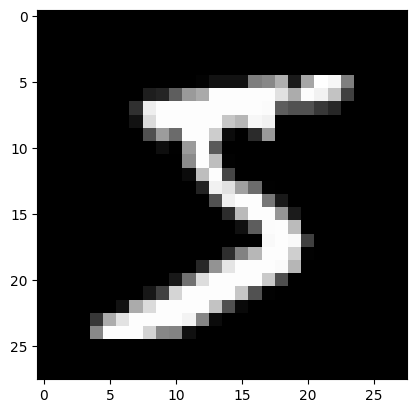

In [42]:
image, label = datasets[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

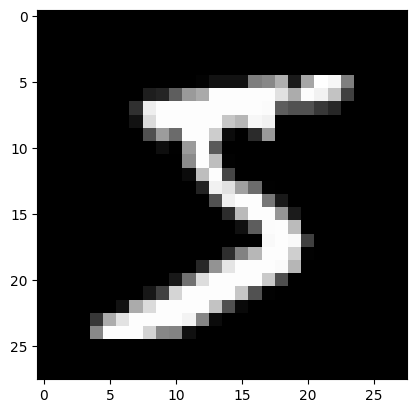

In [43]:
datasets = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
img_tensor, label = datasets[0]
plt.imshow(img_tensor[0], cmap='gray')

In [44]:
n = len(datasets)
val_pct = 0.2
n_val = int(val_pct * n)
idxs = torch.randperm(n)

In [45]:
import numpy as np

def split_indices(n, val_pct):
    n_val = int(val_pct * n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]


In [46]:
train_indices, val_indices = split_indices(len(datasets), val_pct=0.2)
print(len(train_indices), len(val_indices))

48000 12000


In [47]:
batch_size = 100
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, sampler=train_sampler)

val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(datasets, batch_size=batch_size, sampler=val_sampler)

In [48]:
#because model expects a 2D tensor as input, we need to flatten the image 
#tensors
import torch.nn as nn
input_size = 28*28
num_classes = 10
learning_rate = 0.001
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784) # -1 means that the first dimension can be anything
        out = self.linear(xb)
        return out
model = MnistModel()

Now We Want Output to represent probabilities and add up to 1 so we normalise the predicted values using softmax function 

In [49]:
import torch.nn.functional as F

In [50]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

This Cannot be used as Loss Function as it is not differentiable so we want some other loss function
We use Cross Entropy Loss function for this.

In [51]:
loss_fn = F.cross_entropy

Optimizer

In [52]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        metric_result = metric(model(xb), yb)
    return loss.item(), len(xb), metric_result

In [53]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results) #unzipping
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None: #what is metric? accuracy
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total, avg_metric

In [54]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss_batch(model, loss_fn, xb, yb, opt)
        
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        if metric is None:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__, val_metric))

In [55]:
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [56]:
fit(20, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/20], Loss: 1.8728, accuracy: 0.6737
Epoch [2/20], Loss: 1.5779, accuracy: 0.7453
Epoch [3/20], Loss: 1.3709, accuracy: 0.7751
Epoch [4/20], Loss: 1.2219, accuracy: 0.7917
Epoch [5/20], Loss: 1.1111, accuracy: 0.8038
Epoch [6/20], Loss: 1.0261, accuracy: 0.8131
Epoch [7/20], Loss: 0.9589, accuracy: 0.8189
Epoch [8/20], Loss: 0.9046, accuracy: 0.8240
Epoch [9/20], Loss: 0.8596, accuracy: 0.8285
Epoch [10/20], Loss: 0.8219, accuracy: 0.8315
Epoch [11/20], Loss: 0.7897, accuracy: 0.8352
Epoch [12/20], Loss: 0.7619, accuracy: 0.8379
Epoch [13/20], Loss: 0.7375, accuracy: 0.8407
Epoch [14/20], Loss: 0.7161, accuracy: 0.8437
Epoch [15/20], Loss: 0.6970, accuracy: 0.8458
Epoch [16/20], Loss: 0.6799, accuracy: 0.8478
Epoch [17/20], Loss: 0.6645, accuracy: 0.8495
Epoch [18/20], Loss: 0.6505, accuracy: 0.8520
Epoch [19/20], Loss: 0.6378, accuracy: 0.8530
Epoch [20/20], Loss: 0.6261, accuracy: 0.8551


In [57]:
test_datasets = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [58]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


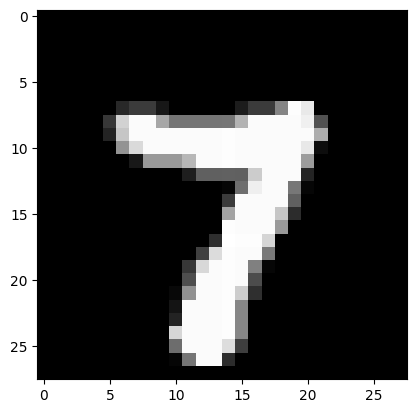

In [59]:
img, label = test_datasets[1100]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [60]:
def evaluate_model_with_batches(test_loader, model):
    correct = 0
    total = 0

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        for images, labels in test_loader:
            # Get model predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)

            # Update the total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy on the entire test dataset: {accuracy:.2f}%')



In [62]:
from torch.utils.data import DataLoader
test_loader = DataLoader(dataset=test_datasets, batch_size=64, shuffle=True)
evaluate_model_with_batches(test_loader, model)

Accuracy on the entire test dataset: 86.88%
